# Interpolating Stellar Evolution Data

You can always modify particle parameters between calls to `sim.integrate`. If you want to interpolate stellar evolution data, you can use the `Interpolator` class to spline a discrete set of time-parameter values.

We begin by setting up the Sun-Earth system, roughly 4 million years before the tip of the red-giant branch (RGB).

In [1]:
import numpy as np
import rebound
import reboundx

M0 = 0.8645388227818771 # initial mass of star
R0 = 0.3833838293200158 # initial radius of star

def makesim():
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2 # use units of AU, yrs and solar masses
    sim.add(m=M0, r=R0, hash="Star")
    sim.add(a=1., hash="Earth")
    sim.integrator = "whfast"
    sim.dt = 0.1*sim.particles[1].P
    sim.move_to_com()
    return sim

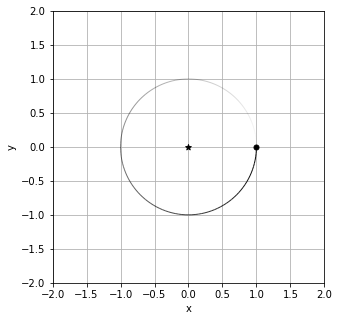

In [2]:
%matplotlib inline
sim = makesim()
ps = sim.particles
fig, ax = rebound.OrbitPlot(sim)
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
ax.grid()

CPU times: user 26.1 s, sys: 26.6 s, total: 52.7 s
Wall time: 52.7 s


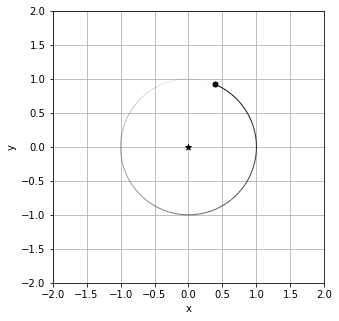

In [3]:
%%time
# CONTROL TEST W/O INTERPOLATIONS
Nout = 1000
mass = np.zeros(Nout)
radius = np.zeros(Nout)
a = np.zeros(Nout)
ts = np.linspace(0., 4.e6, Nout)
T0 = 1.23895e10 # Sun's age at simulation start

for i, time in enumerate(ts):
    sim.integrate(time)
    a[i] = sim.particles[1].a
    
fig, ax = rebound.OrbitPlot(sim)
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
ax.grid()

In [4]:
import numpy as np
import rebound
import reboundx

M0 = 0.8645388227818771 # initial mass of star
R0 = 0.3833838293200158 # initial radius of star

def makesim():
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2 # use units of AU, yrs and solar masses
    sim.add(m=M0, r=R0, hash="Star")
    sim.add(a=1., hash="Earth")
    sim.integrator = "whfast"
    sim.dt = 0.1*sim.particles[1].P
    sim.move_to_com()
    return sim

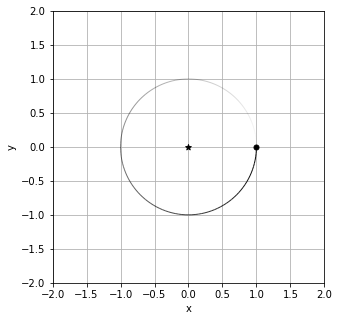

In [5]:
%matplotlib inline
sim = makesim()
ps = sim.particles
fig, ax = rebound.OrbitPlot(sim)
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
ax.grid()

Next we read in external, stellar evolution data (from _MESA: Modules for Experiments in Stellar Astrophysics_) and store the relevant values in a Numpy `ndarray`.

In [6]:
import mesa_reader as mr

mesa = mr.MesaData('history_to_end_agb.data')
# the following are numpy.ndarrays
times = mesa.star_age   # in yr
masses = mesa.star_mass # in Msun
Rsuns = mesa.radius     # in Rsun

# convert Rsun units to AU
radii = np.zeros(Rsuns.size)
for i, rad in enumerate(Rsuns):
    radii[i] = rad * 0.00465047

Now we can create an `Interpolator` object for each parameter set and pass the corresponding arrays as arguments.

In [7]:
rebx = reboundx.Extras(sim)

starmass = reboundx.Interpolator(rebx, times, masses, "spline")
starradius = reboundx.Interpolator(rebx, times, radii, "spline")

Finally, we integrate for 4 Myr and plot the resulting system:

CPU times: user 30 s, sys: 24.2 s, total: 54.1 s
Wall time: 54.1 s


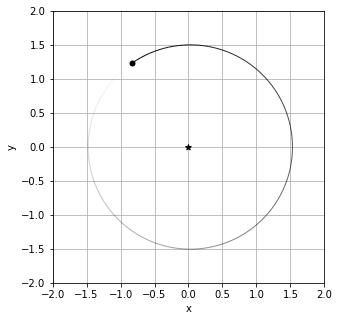

In [8]:
%%time
Nout = 1000
mass = np.zeros(Nout)
radius = np.zeros(Nout)
a = np.zeros(Nout)
ts = np.linspace(0., 4.e6, Nout)
# ts = np.linspace(0., 1.e6, Nout)
T0 = 1.23895e10 # Sun's age at simulation start

for i, time in enumerate(ts):
    sim.integrate(time)
    ps[0].m = starmass.interpolate(rebx, t=T0+sim.t)
    ps[0].r = starradius.interpolate(rebx, t=T0+sim.t)
    sim.move_to_com() # lost mass had momentum, so need to move back to COM frame
    mass[i] = sim.particles[0].m
    radius[i] = sim.particles[0].r
    a[i] = sim.particles[1].a
    
fig, ax = rebound.OrbitPlot(sim)
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
ax.grid()

We see that, as the Sun loses mass along its RGB phase, the Earth has correspondingly and adiabatically expanded, as one might expect. Let's now plot the Sun's mass over time, and a comparison of the Sun's radius and Earth's semi-major axis over time, adjacent to one another.

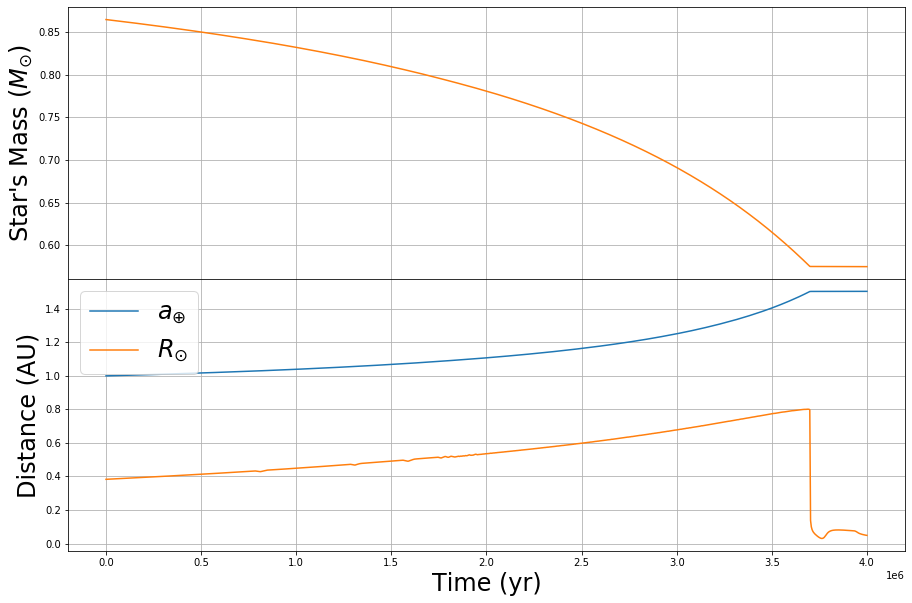

In [9]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15,10))
fig.subplots_adjust(hspace=0)
ax1.set_ylabel("Star's Mass ($M_{\odot}$)", fontsize=24)
ax1.plot(ts,mass, color="tab:orange")
ax1.grid()
ax2.set_xlabel("Time (yr)", fontsize=24)
ax2.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax2.set_ylabel("Distance (AU)", fontsize=24)
ax2.plot(ts,a, label="$a_{\oplus}$")
ax2.plot(ts,radius, label='$R_{\odot}$')
ax2.legend(fontsize=24, loc="best")
ax2.grid()